Implementing Rotary Positional Embedding
#### **The Math**

*Rotary encoding transforms pairs of features by rotating in the 2D plane. That is, it organizes the d features as d/2
pairs. Each pair can be considered a coordinate in a 2D plane, and the encoding will rotate it by an angle depending on the position of the token.*

$$\text{Let } x_m^{(1)} \text{ and } x_m^{(2)} \text {be two features of the key or}\\
 \text{query of any head at position m.}\\
 \text{For simplicity assume x has only two features. Then the transformation is:}$$


$$\text{RoPE}(x_m^{(1)}, x_m^{(2)}, m) =
\begin{bmatrix}
\cos(m\theta) & -\sin(m\theta) \\
\sin(m\theta) & \cos(m\theta)
\end{bmatrix}
\begin{bmatrix}
x_m^{(1)} \\
x_m^{(2)}
\end{bmatrix}
= \begin{bmatrix}
x_m^{(1)}\cos(m\theta) - x_m^{(2)}\sin(m\theta) \\
x_m^{(2)}\cos(m\theta) + x_m^{(1)}\sin(m\theta)
\end{bmatrix}$$


$$ \Theta = \theta_i = 10,000^{-\frac{2(i-1)}{d}} , where ( i \in [1, 2, ..., 2d] ) \text{ for the ( 2d ) pairs of features.}$$

In [1]:
import torch 
import matplotlib.pyplot as plt
import numpy as np 

''' The chnage was as from the traditonal positional encoding, not just using some sine and cosine, although they carry some information but face challenge when long context have to remember. So the key idea is to rotate the token embedding
in a multi-dimensional spaced based on their position. Each token embedding is rotated by an angle proportional to it sequence position'''

class Rotary_postional:
    def __init__(self, d_model, max_seq_len=5000, base=10000):
        self.d_model= d_model
        self.max_seq_len= max_seq_len # maximum sequence length we may encounter
        self.base= base # for the geometric progression of frequencies usually(10,000)

        ''' precompute frequencies for each dimension pair
        -> torch.arange(0, d_model, 2) gives [0, 2, 4, ..., d_model-2]
        This represents indices for each pair of dimensions
        
        -> The formula: 1 / (base^(2i/d_model)) creates frequencies that:
         - Decrease as dimension index increases
         - First dimensions rotate fastest, last dimensions rotate slowest 

         Example with d_model=8:
         i = [0, 2, 4, 6]
         2i/d_model = [0, 0.5, 1.0, 1.5]
         base^(2i/d_model) = [1, 100, 10000, 1000000]
         freq = [1.0, 0.01, 0.0001, 0.000001] '''

        self.frequency = 1.0/(self.base ** (torch.arange(0,d_model,2).float()/d_model))

    def get_embeddings(self,seq_len):
        '''generate sine and cosine embeddings for each position'''

        position = torch.arange(seq_len).float().unsqueeze(1) # position indices

        # calculate angle for each 
        # position shape: (seq_len, 1)
        # inv_freq shape: (d_model/2,)
        # Broadcasting results in freqs shape: (seq_len, d_model/2)
        # 
        # Each element freqs[i,j] = position[i] * inv_freq[j]
        # This represents the angle for position i and dimension pair j

        freq = position * self.frequency

        # apply sine and cosine to get embeddings
        sin_embed = torch.sin(freq)
        cos_embed = torch.cos(freq)

        return sin_embed, cos_embed

    def apply_rotary(self, x, seq_len=None):
        '''
        Apply rotary embeddings to input tensor x
        
        The key idea: For each pair of dimensions (2i, 2i+1), apply a 2D rotation
        based on the position in the sequence.
        
        Rotation formula for 2D:
        [x']   [cos θ  -sin θ] [x]
        [y'] = [sin θ   cos θ] [y]
        
        Which gives:
        x' = x*cos(θ) - y*sin(θ)
        y' = x*sin(θ) + y*cos(θ)
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, d_model)
            seq_len: Optional sequence length (uses x.size(1) if not provided)
        
        Returns:
            Tensor with rotary embeddings applied, same shape as input
        '''
        
        if seq_len is None:
            seq_len = x.size(1)

        sin_embed, cos_embed = self.get_embeddings(seq_len) # get both embeddings for sequnce length

            # Reshape x to separate pairs of dimensions
        # Original x shape: (batch_size, seq_len, d_model)
        # After view: (batch_size, seq_len, d_model/2, 2)
        # This groups consecutive dimensions into pairs
        x_reshape = x.view(x.size(0), x.size(1), -1, 2)
        
        # Extract the first and second element of each pair
        # x_1 shape: (batch_size, seq_len, d_model/2) - contains dims 0,2,4,6,...
        # x_2 shape: (batch_size, seq_len, d_model/2) - contains dims 1,3,5,7,...
        x_1 = x_reshape[..., 0]  # First element of each pair
        x_2 = x_reshape[..., 1]  # Second element of each pair
        
        # Prepare sin/cos for broadcasting with batch dimension
        # Original shape: (seq_len, d_model/2)
        # After unsqueeze(0): (1, seq_len, d_model/2)
        # After expand: (batch_size, seq_len, d_model/2)
        sin_embed = sin_embed.unsqueeze(0).expand(x.size(0), -1, -1)
        cos_embed = cos_embed.unsqueeze(0).expand(x.size(0), -1, -1)
        
        # Apply 2D rotation formula to each pair
        # For each position and dimension pair, we rotate the vector (x_1, x_2)
        # by an angle that depends on the position and dimension
        rotated_1 = x_1 * cos_embed - x_2 * sin_embed  # New first element
        rotated_2 = x_1 * sin_embed + x_2 * cos_embed  # New second element
        
        # Combine the rotated pairs back together
        # Stack along the last dimension to recreate pairs
        # rotated shape: (batch_size, seq_len, d_model/2, 2)
        rotated = torch.stack([rotated_1, rotated_2], dim=-1)
        
        # Reshape back to original dimensions
        # Final shape: (batch_size, seq_len, d_model)
        return rotated.view(x.size(0), x.size(1), -1)


In [2]:
def visualize_rotation_2d():
    """Visualize how RoPE performs 2D rotations"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Create a simple 2D vector
    original_vector = np.array([1, 0])
    
    # Different positions
    positions = [0, 10, 20]
    colors = ['blue', 'green', 'red']
    
    for idx, (pos, color) in enumerate(zip(positions, colors)):
        ax = axes[idx]
        
        # Calculate rotation angle (simplified for visualization)
        theta = pos * 2 * np.pi / 50  # Arbitrary scaling for visualization
        
        # Rotation matrix
        cos_theta = np.cos(theta)
        sin_theta = np.sin(theta)
        
        # Apply rotation
        rotated_vector = np.array([
            original_vector[0] * cos_theta - original_vector[1] * sin_theta,
            original_vector[0] * sin_theta + original_vector[1] * cos_theta
        ])
        
        # Plot
        ax.arrow(0, 0, original_vector[0], original_vector[1], 
                head_width=0.1, head_length=0.1, fc='black', ec='black', 
                linewidth=2, label='Original')
        ax.arrow(0, 0, rotated_vector[0], rotated_vector[1], 
                head_width=0.1, head_length=0.1, fc=color, ec=color, 
                linewidth=2, label=f'Position {pos}')
        
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
        ax.set_title(f'Rotation at Position {pos}')
        ax.legend()
        
        # Add angle annotation
        ax.text(0.5, -1.3, f'θ = {theta:.2f} rad', fontsize=10)
    
    plt.tight_layout()
    plt.show()

Input shape: torch.Size([2, 50, 64])
Output shape: torch.Size([2, 50, 64])

Generating visualizations...


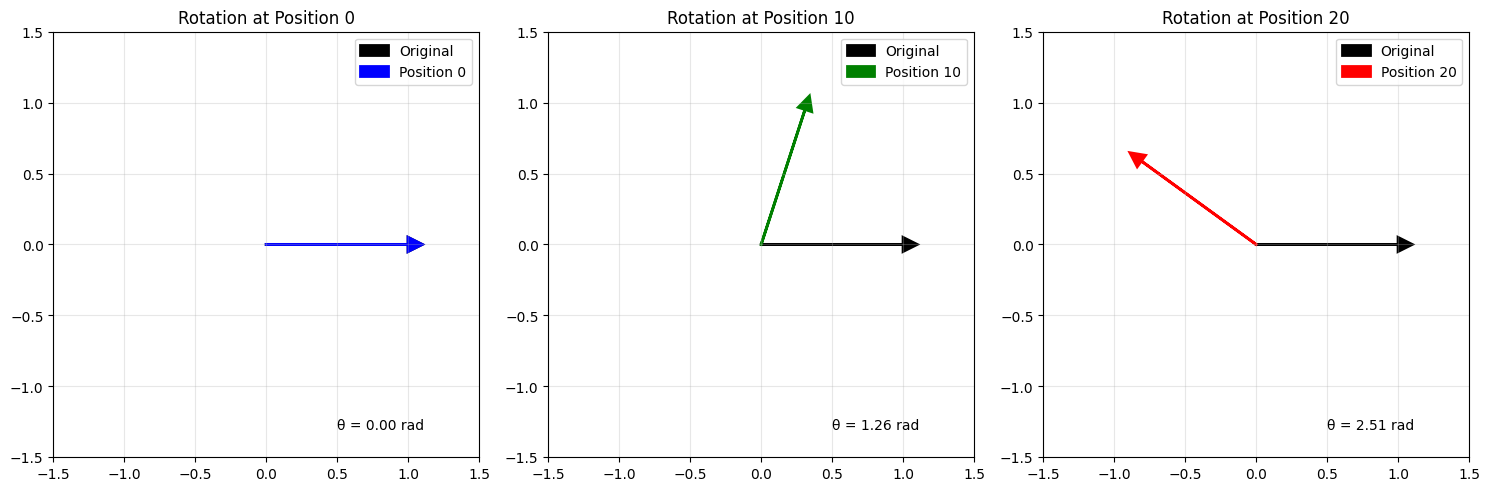

In [3]:
d_model = 64
seq_len=50
batch_size =2

rotate = Rotary_postional(d_model)

x = torch.rand(batch_size, seq_len, d_model)

x_rotate = rotate.apply_rotary(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {x_rotate.shape}")
    
    # Visualize
print("\nGenerating visualizations...")
visualize_rotation_2d()

In [4]:
print(f"original input matrix \n:{x[0].numpy()}")
print("--------------")
print(f"rotated embedding \n :{x_rotate[0].numpy()}")

original input matrix 
:[[7.6802963e-01 6.0080254e-01 5.6388444e-01 ... 1.1267859e-01
  1.4363080e-01 6.7858577e-02]
 [7.0126057e-02 9.0160728e-01 5.4194158e-01 ... 8.1909972e-01
  9.5109284e-02 5.7218021e-01]
 [9.5793843e-02 8.5225123e-01 9.2960685e-01 ... 3.8257593e-01
  5.5473399e-01 8.3640969e-01]
 ...
 [4.6906686e-01 4.6761870e-01 8.8706928e-01 ... 9.7671831e-01
  4.1968870e-01 1.6312516e-01]
 [6.9442326e-01 2.3892462e-01 2.5460750e-01 ... 4.7206980e-01
  2.8622454e-01 9.8917401e-01]
 [6.3500196e-01 5.7691813e-02 3.2080567e-01 ... 9.3030930e-04
  3.2634485e-01 5.1804602e-02]]
--------------
rotated embedding 
 :[[ 0.76802963  0.60080254  0.56388444 ...  0.11267859  0.1436308
   0.06785858]
 [-0.72078705  0.54614955 -0.0950911  ...  0.8192533   0.09503298
   0.5721929 ]
 [-0.81481415 -0.26755658 -0.78760356 ...  0.38278362  0.5545109
   0.8365576 ]
 ...
 [-0.5232568  -0.40607056 -0.07196778 ...  0.9823034   0.41865808
   0.16575235]
 [-0.26097617 -0.6864401   0.7107003  ...  0.4776